### **Tổng quan Dataset**

#### **Mục tiêu (Objectives)**

- Đánh giá chất lượng dữ liệu tổng thể
- Hiểu cấu trúc và quy mô dataset qua 4 năm
- Xác định các vấn đề dữ liệu cần xử lý

#### **Key Questions to Answer (Câu hỏi chính cần trả lời)**

- Dữ liệu có đầy đủ và chính xác không?
- Có gaps nào trong timeline 4 năm không?
- Dữ liệu có đủ để phân tích toàn diện không?
- Có outliers hoặc anomalies nào cần chú ý không?

In [1]:
# Import các thư viện cần thiết
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from dotenv import load_dotenv
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)      # Hiển thị tất cả cột
pd.set_option('display.width', None)            # Không giới hạn chiều rộng
pd.set_option('display.max_colwidth', None)     # Không giới hạn độ rộng cột

# Load biến môi trường từ file .env
load_dotenv()

# Lấy thông tin kết nối database
DB_USER = os.getenv("DB_USER")
DB_PASS = os.getenv("DB_PASS")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_GOLD = os.getenv("DB_GOLD")

# Tạo kết nối tới Gold database
gold_engine = create_engine(f"mysql+pymysql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_GOLD}")

In [2]:
# Load du lieu tat ca cac bang

df_orders = pd.read_sql_table("fact_orders", gold_engine)
df_orders_items = pd.read_sql_table("fact_order_items", gold_engine)
df_products = pd.read_sql_table("dim_products", gold_engine)
df_customers = pd.read_sql_table("dim_customers", gold_engine)
df_date = pd.read_sql_table("dim_date", gold_engine)
df_pages = pd.read_sql_table("dim_order_pages", gold_engine)
df_payments = pd.read_sql_table("dim_order_payments", gold_engine)
df_shipping = pd.read_sql_table("dim_order_shipping", gold_engine)
df_warehouses = pd.read_sql_table("dim_order_warehouses", gold_engine)
df_shop = pd.read_sql_table("dim_shop", gold_engine) 

#### 1. Data quanlity assessment 

In [8]:
# 1.1. Check missing values

def check_missing_values_high_threshold(dataframes, threshold=0.7):
    """
    Kiểm tra giá trị thiếu trong tất cả các DataFrame và in ra những cột có tỷ lệ null trên threshold
    
    Parameters:
    -----------
    dataframes : dict
        Dictionary chứa tên và DataFrame
    threshold : float, default 0.7
        Ngưỡng tỷ lệ null (0.7 = 70%)
    
    Returns:
    --------
    dict: Dictionary chứa thông tin missing values cho mỗi DataFrame
    """
    
    results = {}
    
    print("KIỂM TRA GIÁ TRỊ THIẾU - CÁC CỘT CÓ TỶ LỆ NULL TRÊN 70%")
    print("=" * 80)
    
    for name, df in dataframes.items():
        print(f"\nBẢNG: {name.upper()}")
        print(f"Kích thước: {df.shape[0]} rows x {df.shape[1]} columns")
        print("-" * 60)
        
        # Tính tỷ lệ missing values cho mỗi cột
        missing_stats = df.isnull().sum()
        missing_percent = (missing_stats / len(df)) * 100
        
        # Lọc các cột có tỷ lệ null trên threshold
        high_missing_cols = missing_percent[missing_percent > (threshold * 100)]
        
        if len(high_missing_cols) > 0:
            print(f"⚠️  CÁC CỘT CÓ TỶ LỆ NULL TRÊN {threshold*100}%:")
            for col, percent in high_missing_cols.items():
                null_count = missing_stats[col]
                print(f"   • {col}: {null_count:,} null values ({percent:.2f}%)")
        else:
            print(f"✅ Không có cột nào có tỷ lệ null trên {threshold*100}%")
        
        # Thống kê tổng quan
        total_missing = missing_stats.sum()
        total_cells = df.shape[0] * df.shape[1]
        overall_missing_percent = (total_missing / total_cells) * 100
        
        print(f"\n THỐNG KÊ TỔNG QUAN:")
        print(f"   • Tổng số giá trị thiếu: {total_missing:,}")
        print(f"   • Tỷ lệ missing tổng thể: {overall_missing_percent:.2f}%")
        print(f"   • Số cột có missing values: {len(missing_stats[missing_stats > 0])}")
        
        # Lưu kết quả
        results[name] = {
            'shape': df.shape,
            'missing_stats': missing_stats,
            'missing_percent': missing_percent,
            'high_missing_cols': high_missing_cols,
            'overall_missing_percent': overall_missing_percent
        }
        
        print("=" * 60)
    
    return results

# Tạo dictionary chứa tất cả các DataFrame
dataframes = {
    'fact_orders': df_orders,
    'fact_order_items': df_orders_items,
    'dim_products': df_products,
    'dim_customers': df_customers,
    'dim_date': df_date,
    'dim_order_pages': df_pages,
    'dim_order_payments': df_payments,
    'dim_order_shipping': df_shipping,
    'dim_order_warehouses': df_warehouses,
    'dim_shop': df_shop
}

# Chạy kiểm tra
missing_results = check_missing_values_high_threshold(dataframes, threshold=0.7)

KIỂM TRA GIÁ TRỊ THIẾU - CÁC CỘT CÓ TỶ LỆ NULL TRÊN 70%

BẢNG: FACT_ORDERS
Kích thước: 40236 rows x 25 columns
------------------------------------------------------------
✅ Không có cột nào có tỷ lệ null trên 70.0%

 THỐNG KÊ TỔNG QUAN:
   • Tổng số giá trị thiếu: 10
   • Tỷ lệ missing tổng thể: 0.00%
   • Số cột có missing values: 1

BẢNG: FACT_ORDER_ITEMS
Kích thước: 46611 rows x 11 columns
------------------------------------------------------------
✅ Không có cột nào có tỷ lệ null trên 70.0%

 THỐNG KÊ TỔNG QUAN:
   • Tổng số giá trị thiếu: 0
   • Tỷ lệ missing tổng thể: 0.00%
   • Số cột có missing values: 0

BẢNG: DIM_PRODUCTS
Kích thước: 37 rows x 18 columns
------------------------------------------------------------
✅ Không có cột nào có tỷ lệ null trên 70.0%

 THỐNG KÊ TỔNG QUAN:
   • Tổng số giá trị thiếu: 6
   • Tỷ lệ missing tổng thể: 0.90%
   • Số cột có missing values: 2

BẢNG: DIM_CUSTOMERS
Kích thước: 36090 rows x 26 columns
-------------------------------------------

In [26]:
def visualize_missing_bubble_chart_from_results(missing_results, dataframes):

    # Chuẩn bị dữ liệu cho bubble chart
    bubble_data = []
    
    for name, result in missing_results.items():
        df = dataframes[name]
        missing_percent = result['missing_percent']
        
        # Lấy các cột có missing values
        for col in df.columns:
            if missing_percent[col] > 0:  # Chỉ hiển thị cột có missing values
                bubble_data.append({
                    'table': name,
                    'column': col,
                    'missing_count': result['missing_stats'][col],
                    'missing_percent': missing_percent[col],
                    'table_size': result['shape'][0],
                    'column_type': str(df[col].dtype)
                })
    
    if not bubble_data:
        print("Không có missing values để hiển thị")
        return
    
    # Tạo DataFrame
    bubble_df = pd.DataFrame(bubble_data)
    
    # Tạo biểu đồ
    plt.figure(figsize=(12, 8))
    
    # Tạo mapping cho màu sắc dựa trên tỷ lệ missing
    def get_color(missing_percent):
        if missing_percent > 50:
            return 'red'
        elif missing_percent > 20:
            return 'orange'
        elif missing_percent > 5:
            return 'yellow'
        else:
            return 'lightgreen'
    
    # Vẽ biểu đồ bong bóng
    for i, (table, group) in enumerate(bubble_df.groupby('table')):
        x_pos = i
        y_pos = 0
        
        for _, row in group.iterrows():
            # Tính kích thước bong bóng (tỷ lệ missing * 20 để dễ nhìn)
            bubble_size = row['missing_percent'] * 20
            
            # Vẽ bong bóng
            plt.scatter(x_pos, y_pos, 
                       s=bubble_size, 
                       c=get_color(row['missing_percent']),
                       alpha=0.7,
                       edgecolors='black',
                       linewidth=0.5)
            
            # Thêm label cho cột
            plt.annotate(f"{row['column']}\n{row['missing_percent']:.1f}%", 
                        (x_pos, y_pos), 
                        ha='center', va='center',
                        fontsize=8, fontweight='bold')
            
            y_pos += 1
    
    # Tùy chỉnh biểu đồ
    plt.xlabel('Tên Bảng', fontsize=12, fontweight='bold')
    plt.ylabel('Các Cột có Missing Values', fontsize=12, fontweight='bold')
    plt.title('Biểu đồ Bong bóng Missing Values\n(Kích thước = Tỷ lệ Missing, Màu sắc = Mức độ nghiêm trọng)', 
              fontsize=14, fontweight='bold')
    
    # Đặt tên trục x
    table_names = bubble_df['table'].unique()
    plt.xticks(range(len(table_names)), [name.replace('_', '\n') for name in table_names], rotation=45)
    
    # Thêm legend
    legend_elements = [
        plt.scatter([], [], s=100, c='red', alpha=0.7, label='Nghiêm trọng (>50%)'),
        plt.scatter([], [], s=100, c='orange', alpha=0.7, label='Cảnh báo (20-50%)'),
        plt.scatter([], [], s=100, c='yellow', alpha=0.7, label='Chú ý (5-20%)'),
        plt.scatter([], [], s=100, c='lightgreen', alpha=0.7, label='Bình thường (<5%)')
    ]
    plt.legend()
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

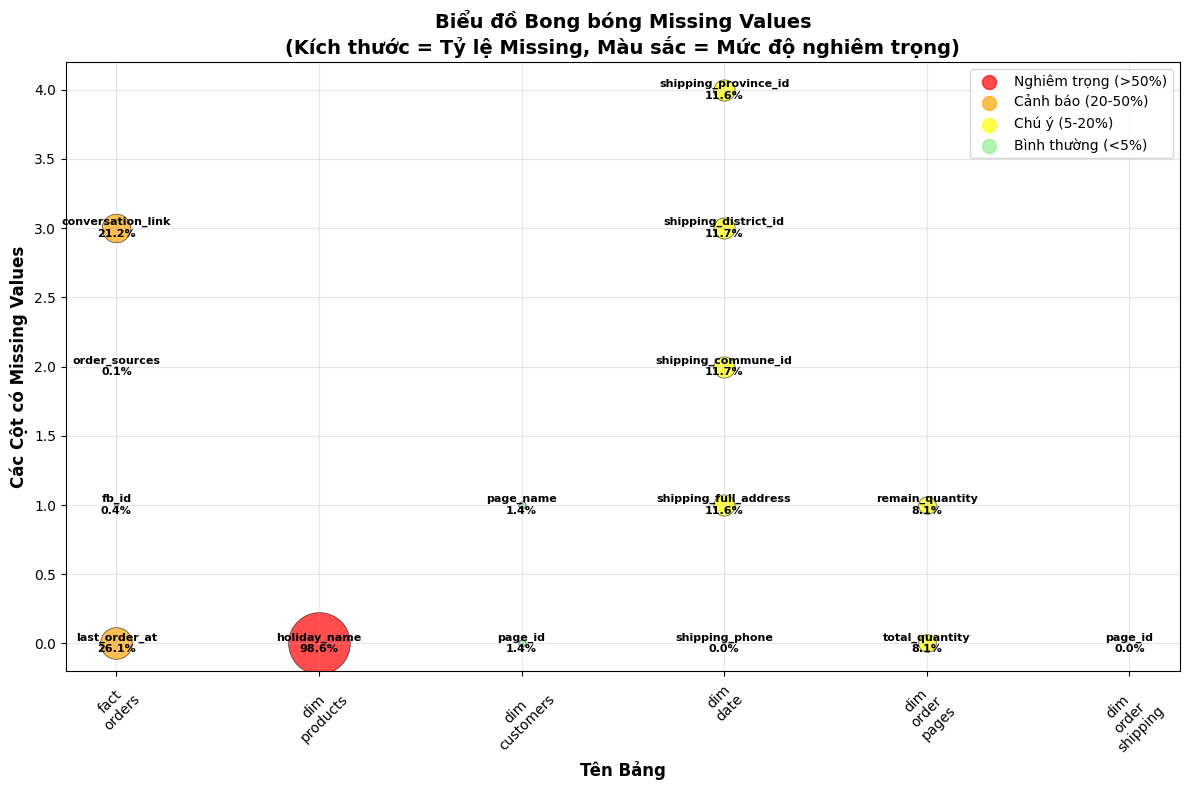

In [27]:
visualize_missing_bubble_chart_from_results(missing_results, dataframes)

In [ ]:
# 1.2. Check orphaned records

def check_orphaned_records_batch(fact_df, dimension_relationships):
    """
    Kiểm tra orphaned records giữa một bảng fact và nhiều bảng dimension
    
    Parameters:
    -----------
    fact_df : DataFrame
        Bảng fact
    dimension_relationships : list
        List các dict với format:
        {
            'dim_df': dataframe,
            'fk_column': str,
            'pk_column': str (optional),
            'name': str (optional)
        }
    
    Returns:
    --------
    dict: Dictionary chứa kết quả cho từng relationship
    """
    
    results = {}
    
    print("=" * 80)
    print(f"ORPHANED RECORDS CHECK - FACT TABLE: {fact_df.name if hasattr(fact_df, 'name') else 'Unknown'}")
    print(f"Total Fact Records: {len(fact_df):,}")
    print("=" * 80)
    
    for i, rel in enumerate(dimension_relationships):
        # Lấy thông tin relationship
        dim_df = rel['dim_df']
        fk_column = rel['fk_column']
        pk_column = rel.get('pk_column', dim_df.columns[0])
        name = rel.get('name', f'Dimension_{i+1}')
        
        # Kiểm tra orphaned records
        fact_fk_values = set(fact_df[fk_column].dropna().unique())
        dim_pk_values = set(dim_df[pk_column].unique())
        
        orphaned = fact_fk_values - dim_pk_values
        orphaned_count = len(orphaned)
        orphaned_percentage = (orphaned_count / len(fact_df)) * 100 if len(fact_df) > 0 else 0
        
        # In kết quả
        print(f"\n{name.upper()}")
        print(f"Dimension Table: {len(dim_df):,} records")
        print(f"Foreign Key: {fk_column}")
        print(f"Primary Key: {pk_column}")
        print("-" * 50)
        print(f"Số orphaned records: {orphaned_count:,} ({orphaned_percentage:.2f}%)")
        
        if orphaned_count > 0:
            print(f"Có {orphaned_count:,} records trong fact table không có reference trong {name}")
        else:
            print("Không có orphaned records")
        
        # Lưu kết quả
        results[name] = {
            'orphaned_count': orphaned_count,
            'orphaned_percentage': orphaned_percentage,
            'dimension_records': len(dim_df),
            'is_consistent': orphaned_count == 0,
            'orphaned_values': list(orphaned)[:10]  # Chỉ lấy 10 giá trị đầu
        }
    
    # Tóm tắt tổng quan
    print("\n" + "=" * 80)
    print("TÓM TẮT TỔNG QUAN")
    print("=" * 80)
    
    total_orphaned = sum(result['orphaned_count'] for result in results.values())
    consistent_relationships = sum(1 for result in results.values() if result['is_consistent'])
    total_relationships = len(results)
    
    print(f"📊 Tổng số relationships: {total_relationships}")
    print(f"✅ Relationships nhất quán: {consistent_relationships}")
    print(f"❌ Relationships có vấn đề: {total_relationships - consistent_relationships}")
    print(f"🔍 Tổng orphaned records: {total_orphaned:,}")
    
    return results

In [14]:
relationships = [
    {
        'dim_df': df_customers,
        'fk_column': 'customer_id',
        'pk_column': 'customer_id',
        'name': 'Customers'
    },
    {
        'dim_df': df_shop,
        'fk_column': 'shop_id',
        'pk_column': 'shop_id',
        'name': 'Shop'
    },
    {
        'dim_df': df_date,
        'fk_column': 'date_id',
        'pk_column': 'date_id',
        'name': 'Date'
    },
    {
        'dim_df': df_pages,
        'fk_column': 'page_id',
        'pk_column': 'page_id',
        'name': 'Pages'
    },
    {
        'dim_df': df_payments,
        'fk_column': 'payment_id',
        'pk_column': 'payment_id',
        'name': 'Payments'
    },
    {
        'dim_df': df_shipping,
        'fk_column': 'shipping_id',
        'pk_column': 'shipping_id',
        'name': 'Shipping'
    },
    {
        'dim_df': df_warehouses,
        'fk_column': 'warehouse_id',
        'pk_column': 'warehouse_id',
        'name': 'Warehouses'
    },
    {
        'dim_df': df_orders_items,
        'fk_column': 'order_id',
        'pk_column': 'order_id',
        'name': 'Orders_Items'
    }
]

results = check_orphaned_records_batch(df_orders, relationships)

ORPHANED RECORDS CHECK - FACT TABLE: Unknown
Total Fact Records: 40,236

CUSTOMERS
Dimension Table: 36,090 records
Foreign Key: customer_id
Primary Key: customer_id
--------------------------------------------------
Số orphaned records: 0 (0.00%)
Không có orphaned records

SHOP
Dimension Table: 1 records
Foreign Key: shop_id
Primary Key: shop_id
--------------------------------------------------
Số orphaned records: 0 (0.00%)
Không có orphaned records

DATE
Dimension Table: 1,386 records
Foreign Key: date_id
Primary Key: date_id
--------------------------------------------------
Số orphaned records: 503 (1.25%)
Có 503 records trong fact table không có reference trong Date

PAGES
Dimension Table: 74 records
Foreign Key: page_id
Primary Key: page_id
--------------------------------------------------
Số orphaned records: 0 (0.00%)
Không có orphaned records

PAYMENTS
Dimension Table: 40,236 records
Foreign Key: payment_id
Primary Key: payment_id
--------------------------------------------